In [2]:
import pandas as pd
import numpy as np

#==============================СБОР ВХОДНЫХ ДАННЫХ==============================#

def parser(a):
    b = pd.read_csv(f'{a}.txt',sep=';')
    b = b.drop(b.columns[[0, 1, 3]], axis=1)
    b = b.rename({'<DATE>':'date','<CLOSE>':f'{a}'}, axis=1)
    return b

imoex = parser('IMOEX')
rtsi = parser('RTSI')
brent = parser('Brent')
sp500 = parser('SP500')
usdrub = parser('USDRUB')

data = rtsi.merge(imoex,how = 'inner')
data = data.merge(brent,how='inner')
data = data.merge(sp500,how='inner')
data = data.merge(usdrub,how='inner')
data = data.drop(['date'], axis = 1)
print(data)
data = data.values

         RTSI    IMOEX  Brent    SP500   USDRUB
0     1802.23  1713.97  97.51  1274.48  30.5100
1     1868.94  1759.46  98.33  1285.96  30.0900
2     1878.14  1749.75  98.40  1283.76  29.9400
3     1870.09  1744.74  98.68  1293.24  30.0000
4     1900.94  1765.30  97.53  1295.02  29.8900
...       ...      ...    ...      ...      ...
2656  1791.44  4135.14  82.17  4682.80  72.3640
2657  1767.58  4120.02  82.27  4700.90  73.0417
2658  1802.52  4149.02  80.21  4688.67  72.5100
2659  1761.96  4093.85  81.05  4704.54  73.0270
2660  1723.74  4016.47  78.45  4697.96  73.4194

[2661 rows x 5 columns]


In [3]:
#==============================ИНЖЕНЕРНЫЕ КОНСТАНТЫ==============================#

def find_index(data, percent_test, percent_val):
    val_index = int(len(data) - len(data)*percent_test/100)
    train_index = int(val_index - val_index*percent_val/100)
    return train_index, val_index
    
train_index, val_index = find_index(data,25,25)
batch_size = 128
oglyadka = 15
future_target = 0
step = 1

#==============================ФУНКЦИЯ НАРЕЗКИ ВХОДНЫХ ДАННЫХ ==============================#

def narezka(dataset,
            target, 
            start_index, 
            end_index, 
            history_size,
            target_size, 
            step, 
            single_prediction=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_prediction:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

# ТОЧЕЧНОЕ ПРОГНОЗИРОВАНИЕ

In [4]:
#=============================БАЗОВОЕ РЕШЕНИЕ с проверкой по К блокам и без==============================#

data1=data.copy()
mean = data1[:val_index].mean(axis=0)
data1 -= mean
std = data1[:val_index].std(axis=0)
data1 /= std

x_train_val_single, y_train_val_single = narezka(dataset = data1,
                                     target = data1[:, 0],
                                     start_index = 0, 
                                     end_index = val_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)
k = 4
num_val_samples = len(x_train_val_single) // k 
all_mae = []
for i in range(k):    
    val_data = x_train_val_single[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train_val_single[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([x_train_val_single[:i * num_val_samples],
                                         x_train_val_single[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([y_train_val_single[:i * num_val_samples],
                                            y_train_val_single[(i + 1) * num_val_samples:]],axis=0)
    #---------------------------------------------------------------------------------------
    preds = partial_train_data[:, -1, 0]
    mae_with_normalization1 = np.mean(np.abs(preds - partial_train_targets))
    #---------------------------------------------------------------------------------------
    all_mae.append(mae_with_normalization1)

data2=data.copy()
mean = data2[:train_index].mean(axis=0)
data2 -= mean
std2 = data2[:train_index].std(axis=0)
data2 /= std2

x_val_single, y_val_single = narezka(dataset = data2,
                                     target = data2[:, 0],
                                     start_index = train_index+1, 
                                     end_index = val_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

#---------------------------------------------------------------------------------------
preds = x_val_single[:, -1, 0]
mae_with_normalization2 = np.mean(np.abs(preds - y_val_single))
#---------------------------------------------------------------------------------------

print(f'''Базовое решение с проверкой по К блокам: 
    Нормализованное MAE = {np.mean(all_mae)},
    MAE с поправкой на нормализацию = {np.mean(all_mae)*std[0]}.
Базовое решение с простым разбиением начальной выборки: 
    Нормализованное MAE = {mae_with_normalization2},
    MAE с поправкой на нормализацию = {mae_with_normalization2*std2[0]}.''')

Базовое решение с проверкой по К блокам: 
    Нормализованное MAE = 0.05055936704285222,
    MAE с поправкой на нормализацию = 15.219242424242426.
Базовое решение с простым разбиением начальной выборки: 
    Нормализованное MAE = 0.03292476539352714,
    MAE с поправкой на нормализацию = 11.146149068322977.


In [6]:
#==================БАЗОВОЕ РЕШЕНИЕ (НЕГЛУБОКАЯ СВЁРТОЧНАЯ СЕТЬ) с проверкой по К блокам==================#

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

k = 4
num_val_samples = len(x_train_val_single) // k 
num_epochs = 100
all_mae_histories = []
for i in range(k):
    print('НЕГЛУБОКАЯ СВЁРТОЧНАЯ СЕТЬ: Обработка блока #', i,'...')
    
    val_data = x_train_val_single[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train_val_single[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([x_train_val_single[:i * num_val_samples],
                                         x_train_val_single[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([y_train_val_single[:i * num_val_samples],
                                            y_train_val_single[(i + 1) * num_val_samples:]],axis=0)
    
    #---------------------------------------------------------------------------------------
    model = Sequential()
    model.add(layers.Dense(16, activation='relu',input_shape=x_train_val_single.shape[-2:]))
    model.add(layers.Dense(1))
    model.compile(optimizer=RMSprop(), loss='mae')
    #---------------------------------------------------------------------------------------
    
    fitted_model = model.fit(partial_train_data,
                             partial_train_targets,
                             epochs=num_epochs,
                             batch_size=1,
                             validation_data=(val_data, val_targets),
                             verbose=0)
    
    mae_history = fitted_model.history['val_loss']
    all_mae_histories.append(mae_history)

НЕГЛУБОКАЯ СВЁРТОЧНАЯ СЕТЬ: Обработка блока # 0 ...
НЕГЛУБОКАЯ СВЁРТОЧНАЯ СЕТЬ: Обработка блока # 1 ...
НЕГЛУБОКАЯ СВЁРТОЧНАЯ СЕТЬ: Обработка блока # 2 ...
НЕГЛУБОКАЯ СВЁРТОЧНАЯ СЕТЬ: Обработка блока # 3 ...


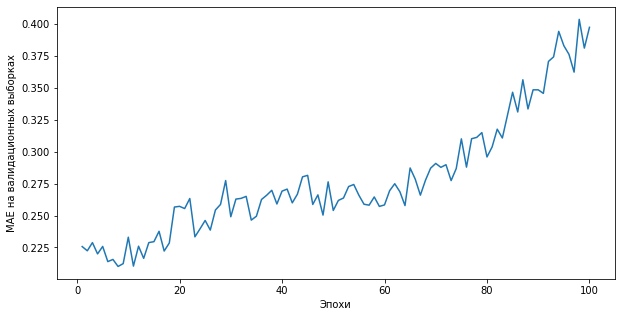

НЕГЛУБОКАЯ СВЁРТОЧНАЯ СЕТЬ с проверкой по К блокам: 
Минимальная средняя абсолютная ошибка c поправкой на нормализацию = 63.257682720056565


In [8]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
a = pd.DataFrame({'average_mae_history':average_mae_history})
a.to_csv('Первый рисунок')

import matplotlib.pyplot as plt

fig=plt.figure(figsize=(10,5))
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Эпохи')
plt.ylabel('MAE на валидационных выборках')
plt.show()

print(f'''НЕГЛУБОКАЯ СВЁРТОЧНАЯ СЕТЬ с проверкой по К блокам: 
Минимальная средняя абсолютная ошибка c поправкой на нормализацию = {min(average_mae_history)*std[0]}''')

In [18]:
#==================БАЗОВОЕ РЕШЕНИЕ (НЕГЛУБОКАЯ СВЁРТОЧНАЯ СЕТЬ) без проверки по К блокам==================#

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

data2=data.copy()
mean = data2[:train_index].mean(axis=0)
data2 -= mean
std = data2[:train_index].std(axis=0)
data2 /= std

x_train_single, y_train_single = narezka(dataset = data2,
                                     target = data2[:, 0],
                                     start_index = 0, 
                                     end_index = train_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

x_val_single, y_val_single = narezka(dataset = data2,
                                     target = data2[:, 0],
                                     start_index = train_index+1, 
                                     end_index = val_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

#---------------------------------------------------------------------------------------
neurons = 16
num_epochs = 100
batch_size = 128

model = Sequential()
model.add(layers.Dense(neurons, activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

fitted_model = model.fit(x_train_single,
                             y_train_single,
                             epochs=num_epochs,
                             batch_size=batch_size,
                             validation_data=(x_val_single, y_val_single),
                             verbose=0)
#---------------------------------------------------------------------------------------

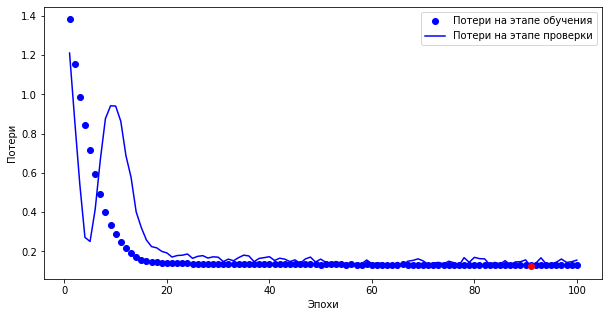

НЕГЛУБОКАЯ СВЁРТОЧНАЯ СЕТЬ без проверки по К блокам: 
Минимальная средняя абсолютная ошибка с поправкой на нормализацию = 41.61718163093223 на 91.0 эпоху.
Архитектура: Dense_neurons = 16, epochs = 100, batch_size = 128.


In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']
# accuracy = fitted_model.history['accuracy']
# val_accuracy = fitted_model.history['val_accuracy']
epochs = range(1, len(loss) + 1)

df = pd.DataFrame(fitted_model.history)
df['epochs'] = epochs
# df.drop(['loss', 'accuracy'], axis=1, inplace=True)

dot_val_loss = df.loc[df.val_loss==min(df.val_loss), ['val_loss', 'epochs']].values[0,0]
dot_val_loss_epochs = df.loc[df.val_loss==min(df.val_loss), ['val_loss', 'epochs']].values[0,1]
# dot_val_accuracy = df.loc[df.val_accuracy==max(df.val_accuracy), ['val_accuracy', 'epochs']].values[0,0]
# dot_val_accuracy_epochs = df.loc[df.val_accuracy==max(df.val_accuracy), ['val_accuracy', 'epochs']].values[0,1]

fig=plt.figure(figsize = (10,5)) #6,15

ax1=plt.subplot(111,xlabel = 'Эпохи', ylabel = 'Потери')
ax1.plot(epochs, loss, 'bo', label='Потери на этапе обучения')
ax1.plot(epochs, val_loss, 'b', label='Потери на этапе проверки')
ax1.plot(dot_val_loss_epochs,dot_val_loss,'ro')
#ax1.text(dot_val_loss_epochs+1,dot_val_loss,f'Потеря={dot_val_loss}\nЭпоха={dot_val_loss_epochs}')
ax1.legend()

# ax2 = plt.subplot(212,title = 'Точность на этапах обучения и проверки',xlabel = 'Эпохи', ylabel = 'Точность')
# ax2.plot(epochs, accuracy, 'bo', label='Точность на этапе обучения')
# ax2.plot(epochs, val_accuracy, 'b', label='Точность на этапе проверки')
# ax2.plot(dot_val_accuracy_epochs,dot_val_accuracy,'ro')
# ax2.text(dot_val_accuracy_epochs+1,dot_val_accuracy,f'Точность={dot_val_accuracy}\nЭпоха={dot_val_accuracy_epochs}')
# ax2.legend()

plt.show()

print(f'''НЕГЛУБОКАЯ СВЁРТОЧНАЯ СЕТЬ без проверки по К блокам: 
Минимальная средняя абсолютная ошибка с поправкой на нормализацию = {dot_val_loss*std[0]} на {dot_val_loss_epochs} эпоху.
Архитектура: Dense_neurons = {neurons}, epochs = {num_epochs}, batch_size = {batch_size}.''')

a = pd.DataFrame({'Потери на этапе обучения':loss,'Потери на этапе проверки':val_loss})
a.to_csv('Второй рисунок')

In [27]:
#==============================БАЗОВОЕ РЕКУРЕНТНОЕ РЕШЕНИЕ==============================#

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

data2=data.copy()
mean = data2[:train_index].mean(axis=0)
data2 -= mean
std = data2[:train_index].std(axis=0)
data2 /= std

x_train_single, y_train_single = narezka(dataset = data2,
                                     target = data2[:, 0],
                                     start_index = 0, 
                                     end_index = train_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

x_val_single, y_val_single = narezka(dataset = data2,
                                     target = data2[:, 0],
                                     start_index = train_index+1, 
                                     end_index = val_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

#---------------------------------------------------------------------------------------
neurons = 16
num_epochs = 100
batch_size = 128

model = Sequential()
model.add(layers.LSTM(neurons,
                      input_shape = x_train_single.shape[-2:]))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

fitted_model = model.fit(x_train_single,
                         y_train_single,
                         epochs=num_epochs,
                         batch_size=batch_size,
                         validation_data=(x_val_single, y_val_single),
                         verbose=0)
#---------------------------------------------------------------------------------------

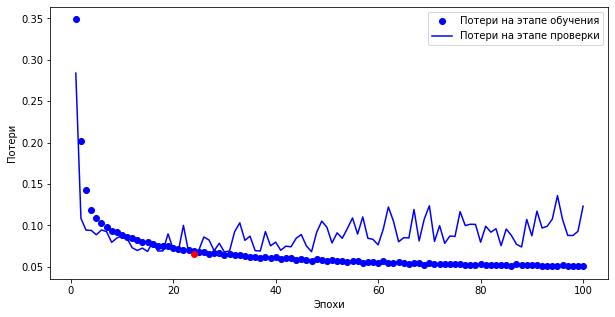

БАЗОВОЕ РЕКУРЕНТНОЕ РЕШЕНИЕ: 
Минимальная средняя абсолютная ошибка с поправкой на нормализацию = 22.230708208989512 на 24.0 эпоху.
Архитектура: LSTM_neurons = 16, epochs = 100, batch_size = 128.


In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']
# accuracy = fitted_model.history['accuracy']
# val_accuracy = fitted_model.history['val_accuracy']
epochs = range(1, len(loss) + 1)

df = pd.DataFrame(fitted_model.history)
df['epochs'] = epochs
# df.drop(['loss', 'accuracy'], axis=1, inplace=True)

dot_val_loss = df.loc[df.val_loss==min(df.val_loss), ['val_loss', 'epochs']].values[0,0]
dot_val_loss_epochs = df.loc[df.val_loss==min(df.val_loss), ['val_loss', 'epochs']].values[0,1]
# dot_val_accuracy = df.loc[df.val_accuracy==max(df.val_accuracy), ['val_accuracy', 'epochs']].values[0,0]
# dot_val_accuracy_epochs = df.loc[df.val_accuracy==max(df.val_accuracy), ['val_accuracy', 'epochs']].values[0,1]

fig=plt.figure(figsize = (10,5)) #6,15

ax1=plt.subplot(111,xlabel = 'Эпохи', ylabel = 'Потери')
ax1.plot(epochs, loss, 'bo', label='Потери на этапе обучения')
ax1.plot(epochs, val_loss, 'b', label='Потери на этапе проверки')
ax1.plot(dot_val_loss_epochs,dot_val_loss,'ro')
#ax1.text(dot_val_loss_epochs+1,dot_val_loss,f'Потеря={dot_val_loss}\nЭпоха={dot_val_loss_epochs}')
ax1.legend()

# ax2 = plt.subplot(212,title = 'Точность на этапах обучения и проверки',xlabel = 'Эпохи', ylabel = 'Точность')
# ax2.plot(epochs, accuracy, 'bo', label='Точность на этапе обучения')
# ax2.plot(epochs, val_accuracy, 'b', label='Точность на этапе проверки')
# ax2.plot(dot_val_accuracy_epochs,dot_val_accuracy,'ro')
# ax2.text(dot_val_accuracy_epochs+1,dot_val_accuracy,f'Точность={dot_val_accuracy}\nЭпоха={dot_val_accuracy_epochs}')
# ax2.legend()

plt.show()

print(f'''БАЗОВОЕ РЕКУРЕНТНОЕ РЕШЕНИЕ: 
Минимальная средняя абсолютная ошибка с поправкой на нормализацию = {dot_val_loss*std[0]} на {dot_val_loss_epochs} эпоху.
Архитектура: LSTM_neurons = {neurons}, epochs = {num_epochs}, batch_size = {batch_size}.''')

a = pd.DataFrame({'Потери на этапе обучения':loss,'Потери на этапе проверки':val_loss})
a.to_csv('Третий рисунок')

In [11]:
#==============================ПОДБОР ГИПЕРПАРМЕТРОВ (ТАБЛИЦА)==============================#

data2=data.copy()
mean = data2[:train_index].mean(axis=0)
data2 -= mean
std = data2[:train_index].std(axis=0)
data2 /= std

x_train_single, y_train_single = narezka(dataset = data2,
                                     target = data2[:, 0],
                                     start_index = 0, 
                                     end_index = train_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

x_val_single, y_val_single = narezka(dataset = data2,
                                     target = data2[:, 0],
                                     start_index = train_index+1, 
                                     end_index = val_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

neurons = [8,16,32,64]
num_epochs = [50,100,200]
batch_size = [64,128]

frame = pd.DataFrame({'Количество входных нейронов':[],
                      'Эпохи всего':[],
                      'Объём пакета':[],
                      'Минимальная MAE':[],
                      'Эпоха минимальной MAE':[]})
for d in range(10):
    for i in neurons:
        for j in num_epochs:
            for g in batch_size:
                model = Sequential()
                model.add(layers.LSTM(i,input_shape = x_train_single.shape[-2:]))
                model.add(layers.Dense(1))
                model.compile(optimizer=RMSprop(), loss='mae')

                fitted_model = model.fit(x_train_single,
                                         y_train_single,
                                         epochs=j,
                                         batch_size=g,
                                         validation_data=(x_val_single, y_val_single),
                                         verbose=0)

                val_loss = fitted_model.history['val_loss']
                epochs = range(1, len(val_loss) + 1)
                df = pd.DataFrame(fitted_model.history)
                df['epochs'] = epochs
                dot_val_loss = df.loc[df.val_loss==min(df.val_loss), ['val_loss', 'epochs']].values[0,0]
                dot_val_loss_epochs = df.loc[df.val_loss==min(df.val_loss), ['val_loss', 'epochs']].values[0,1]

                new_row = {'Количество входных нейронов':i,
                          'Эпохи всего':j,
                          'Объём пакета':g,
                          'Минимальная MAE':dot_val_loss ,
                          'Эпоха минимальной MAE':dot_val_loss_epochs}
                frame = frame.append(new_row, ignore_index=True)
    frame.to_excel(f'Hyperparameters_progon_{d}.xlsx')
    
# ИЗБРАННОЕ: 64;200;64

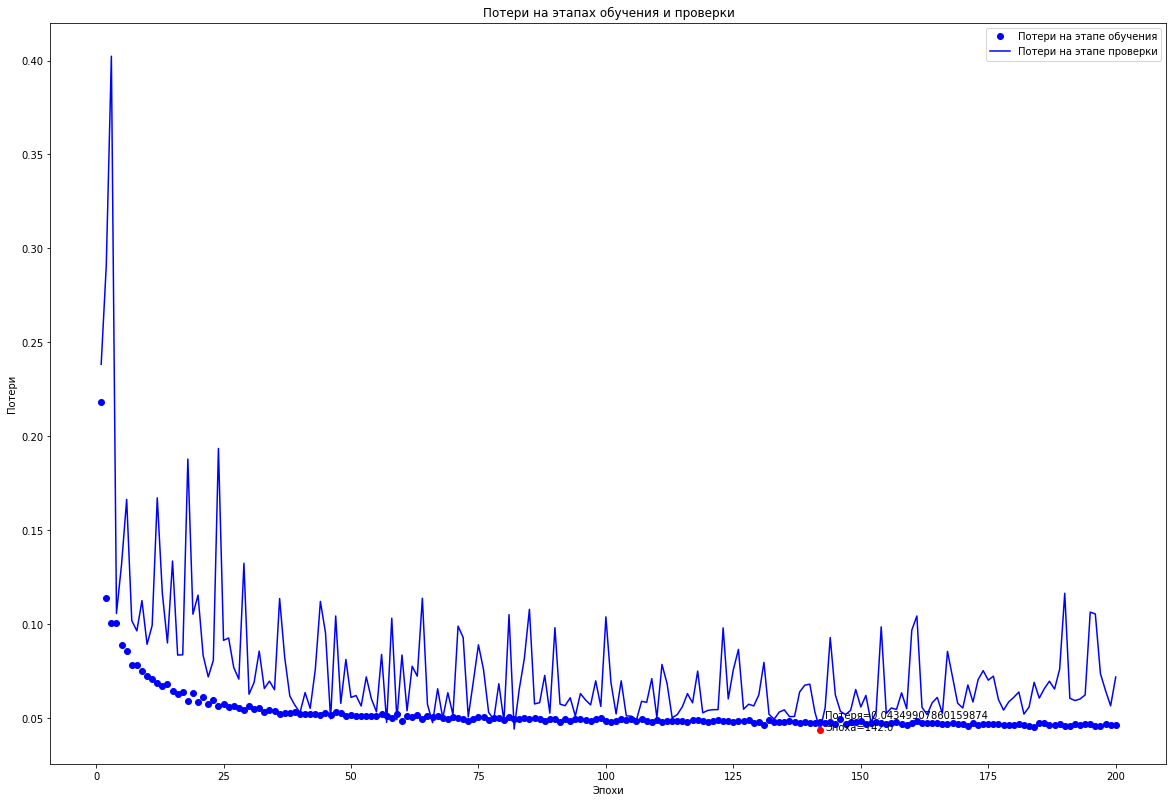

БАЗОВОЕ РЕКУРЕНТНОЕ РЕШЕНИЕ (ДОСТИЖЕНИЕ БЕНЧМАРКА): 
Минимальная средняя абсолютная ошибка с поправкой на нормализацию = 14.725912504859835 на 142.0 эпоху.
Архитектура: LSTM_neurons = 64, epochs = 200, batch_size = 64.


In [5]:
#==============================БАЗОВОЕ РЕКУРЕНТНОЕ РЕШЕНИЕ (ДОСТИЖЕНИЕ БЕНЧМАРКА)==============================#

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

data2=data.copy()
mean = data2[:train_index].mean(axis=0)
data2 -= mean
std = data2[:train_index].std(axis=0)
data2 /= std

x_train_single, y_train_single = narezka(dataset = data2,
                                     target = data2[:, 0],
                                     start_index = 0, 
                                     end_index = train_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

x_val_single, y_val_single = narezka(dataset = data2,
                                     target = data2[:, 0],
                                     start_index = train_index+1, 
                                     end_index = val_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

#---------------------------------------------------------------------------------------
neurons = 64
num_epochs = 200
batch_size = 64

model = Sequential()
model.add(layers.LSTM(neurons,input_shape = x_train_single.shape[-2:]))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

fitted_model = model.fit(x_train_single,
                         y_train_single,
                         epochs=num_epochs,
                         batch_size=batch_size,
                         validation_data=(x_val_single, y_val_single),
                         verbose=0)
#---------------------------------------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']
# accuracy = fitted_model.history['accuracy']
# val_accuracy = fitted_model.history['val_accuracy']
epochs = range(1, len(loss) + 1)

df = pd.DataFrame(fitted_model.history)
df['epochs'] = epochs
# df.drop(['loss', 'accuracy'], axis=1, inplace=True)

dot_val_loss = df.loc[df.val_loss==min(df.val_loss), ['val_loss', 'epochs']].values[0,0]
dot_val_loss_epochs = df.loc[df.val_loss==min(df.val_loss), ['val_loss', 'epochs']].values[0,1]
# dot_val_accuracy = df.loc[df.val_accuracy==max(df.val_accuracy), ['val_accuracy', 'epochs']].values[0,0]
# dot_val_accuracy_epochs = df.loc[df.val_accuracy==max(df.val_accuracy), ['val_accuracy', 'epochs']].values[0,1]

fig=plt.figure(figsize = (20,30)) #6,15

ax1=plt.subplot(211,title = 'Потери на этапах обучения и проверки',xlabel = 'Эпохи', ylabel = 'Потери')
ax1.plot(epochs, loss, 'bo', label='Потери на этапе обучения')
ax1.plot(epochs, val_loss, 'b', label='Потери на этапе проверки')
ax1.plot(dot_val_loss_epochs,dot_val_loss,'ro')
#ax1.text(dot_val_loss_epochs+1,dot_val_loss,f'Потеря={dot_val_loss}\nЭпоха={dot_val_loss_epochs}')
ax1.legend()

# ax2 = plt.subplot(212,title = 'Точность на этапах обучения и проверки',xlabel = 'Эпохи', ylabel = 'Точность')
# ax2.plot(epochs, accuracy, 'bo', label='Точность на этапе обучения')
# ax2.plot(epochs, val_accuracy, 'b', label='Точность на этапе проверки')
# ax2.plot(dot_val_accuracy_epochs,dot_val_accuracy,'ro')
# ax2.text(dot_val_accuracy_epochs+1,dot_val_accuracy,f'Точность={dot_val_accuracy}\nЭпоха={dot_val_accuracy_epochs}')
# ax2.legend()

plt.show()

print(f'''БАЗОВОЕ РЕКУРЕНТНОЕ РЕШЕНИЕ (ДОСТИЖЕНИЕ БЕНЧМАРКА): 
Минимальная средняя абсолютная ошибка с поправкой на нормализацию = {dot_val_loss*std[0]} на {dot_val_loss_epochs} эпоху.
Архитектура: LSTM_neurons = {neurons}, epochs = {num_epochs}, batch_size = {batch_size}.''')

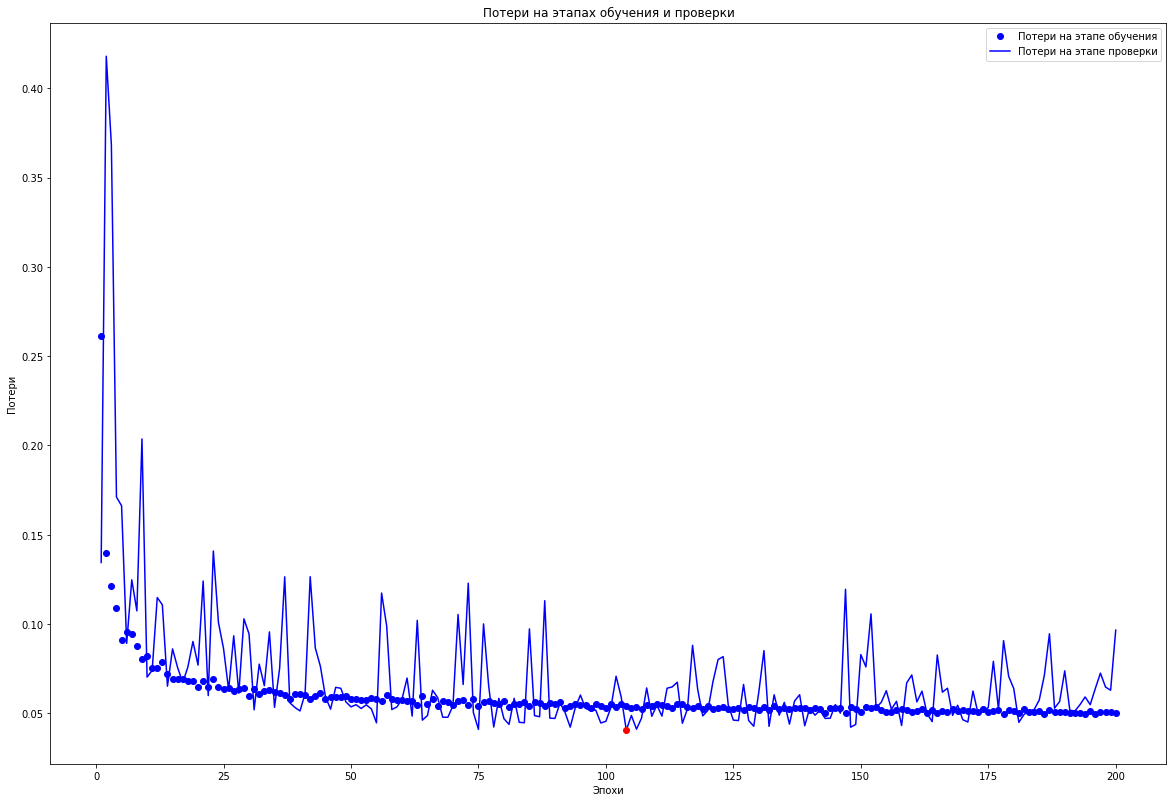

ФИНАЛЬНАЯ АРХИТЕКТУРА (точечный прогноз): 
Минимальная средняя абсолютная ошибка с поправкой на нормализацию = 13.742394610325892 на 104.0 эпоху.
Архитектура: LSTM_neurons = 256, epochs = 200, batch_size = 64.


In [19]:
#==============================ФИНАЛЬНАЯ АРХИТЕКТУРА==============================# 128,100,64, l2=0,001

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras import regularizers

future_target = 0

data2=data.copy()
mean = data2[:train_index].mean(axis=0)
data2 -= mean
std = data2[:train_index].std(axis=0)
data2 /= std

x_train_single, y_train_single = narezka(dataset = data2,
                                     target = data2[:, 0],
                                     start_index = 0, 
                                     end_index = train_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

x_val_single, y_val_single = narezka(dataset = data2,
                                     target = data2[:, 0],
                                     start_index = train_index+1, 
                                     end_index = val_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

#---------------------------------------------------------------------------------------
neurons = 256
num_epochs = 100
batch_size = 64

model = Sequential()
model.add(layers.LSTM(neurons,kernel_regularizer=regularizers.l2(0.001),
                      input_shape = x_train_single.shape[-2:]))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

fitted_model = model.fit(x_train_single,
                         y_train_single,
                         epochs=num_epochs,
                         batch_size=batch_size,
                         validation_data=(x_val_single, y_val_single),
                         verbose=0)
#---------------------------------------------------------------------------------------

import matplotlib.pyplot as plt

loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']
# accuracy = fitted_model.history['accuracy']
# val_accuracy = fitted_model.history['val_accuracy']
epochs = range(1, len(loss) + 1)

df = pd.DataFrame(fitted_model.history)
df['epochs'] = epochs
# df.drop(['loss', 'accuracy'], axis=1, inplace=True)

dot_val_loss = df.loc[df.val_loss==min(df.val_loss), ['val_loss', 'epochs']].values[0,0]
dot_val_loss_epochs = df.loc[df.val_loss==min(df.val_loss), ['val_loss', 'epochs']].values[0,1]
# dot_val_accuracy = df.loc[df.val_accuracy==max(df.val_accuracy), ['val_accuracy', 'epochs']].values[0,0]
# dot_val_accuracy_epochs = df.loc[df.val_accuracy==max(df.val_accuracy), ['val_accuracy', 'epochs']].values[0,1]

fig=plt.figure(figsize = (20,30)) #6,15

ax1=plt.subplot(211,title = 'Потери на этапах обучения и проверки',xlabel = 'Эпохи', ylabel = 'Потери')
ax1.plot(epochs, loss, 'bo', label='Потери на этапе обучения')
ax1.plot(epochs, val_loss, 'b', label='Потери на этапе проверки')
ax1.plot(dot_val_loss_epochs,dot_val_loss,'ro')
#ax1.text(dot_val_loss_epochs+1,dot_val_loss,f'Потеря={dot_val_loss}\nЭпоха={dot_val_loss_epochs}')
ax1.legend()

# ax2 = plt.subplot(212,title = 'Точность на этапах обучения и проверки',xlabel = 'Эпохи', ylabel = 'Точность')
# ax2.plot(epochs, accuracy, 'bo', label='Точность на этапе обучения')
# ax2.plot(epochs, val_accuracy, 'b', label='Точность на этапе проверки')
# ax2.plot(dot_val_accuracy_epochs,dot_val_accuracy,'ro')
# ax2.text(dot_val_accuracy_epochs+1,dot_val_accuracy,f'Точность={dot_val_accuracy}\nЭпоха={dot_val_accuracy_epochs}')
# ax2.legend()

plt.show()

print(f'''ФИНАЛЬНАЯ АРХИТЕКТУРА (точечный прогноз): 
Минимальная средняя абсолютная ошибка с поправкой на нормализацию = {dot_val_loss*std[0]} на {dot_val_loss_epochs} эпоху.
Архитектура: LSTM_neurons = {neurons}, epochs = {num_epochs}, batch_size = {batch_size}.''')

# ВЫПОЛНЕНИЕ ТОЧЕЧНОГО ПРОГНОЗА

<function matplotlib.pyplot.show(close=None, block=None)>

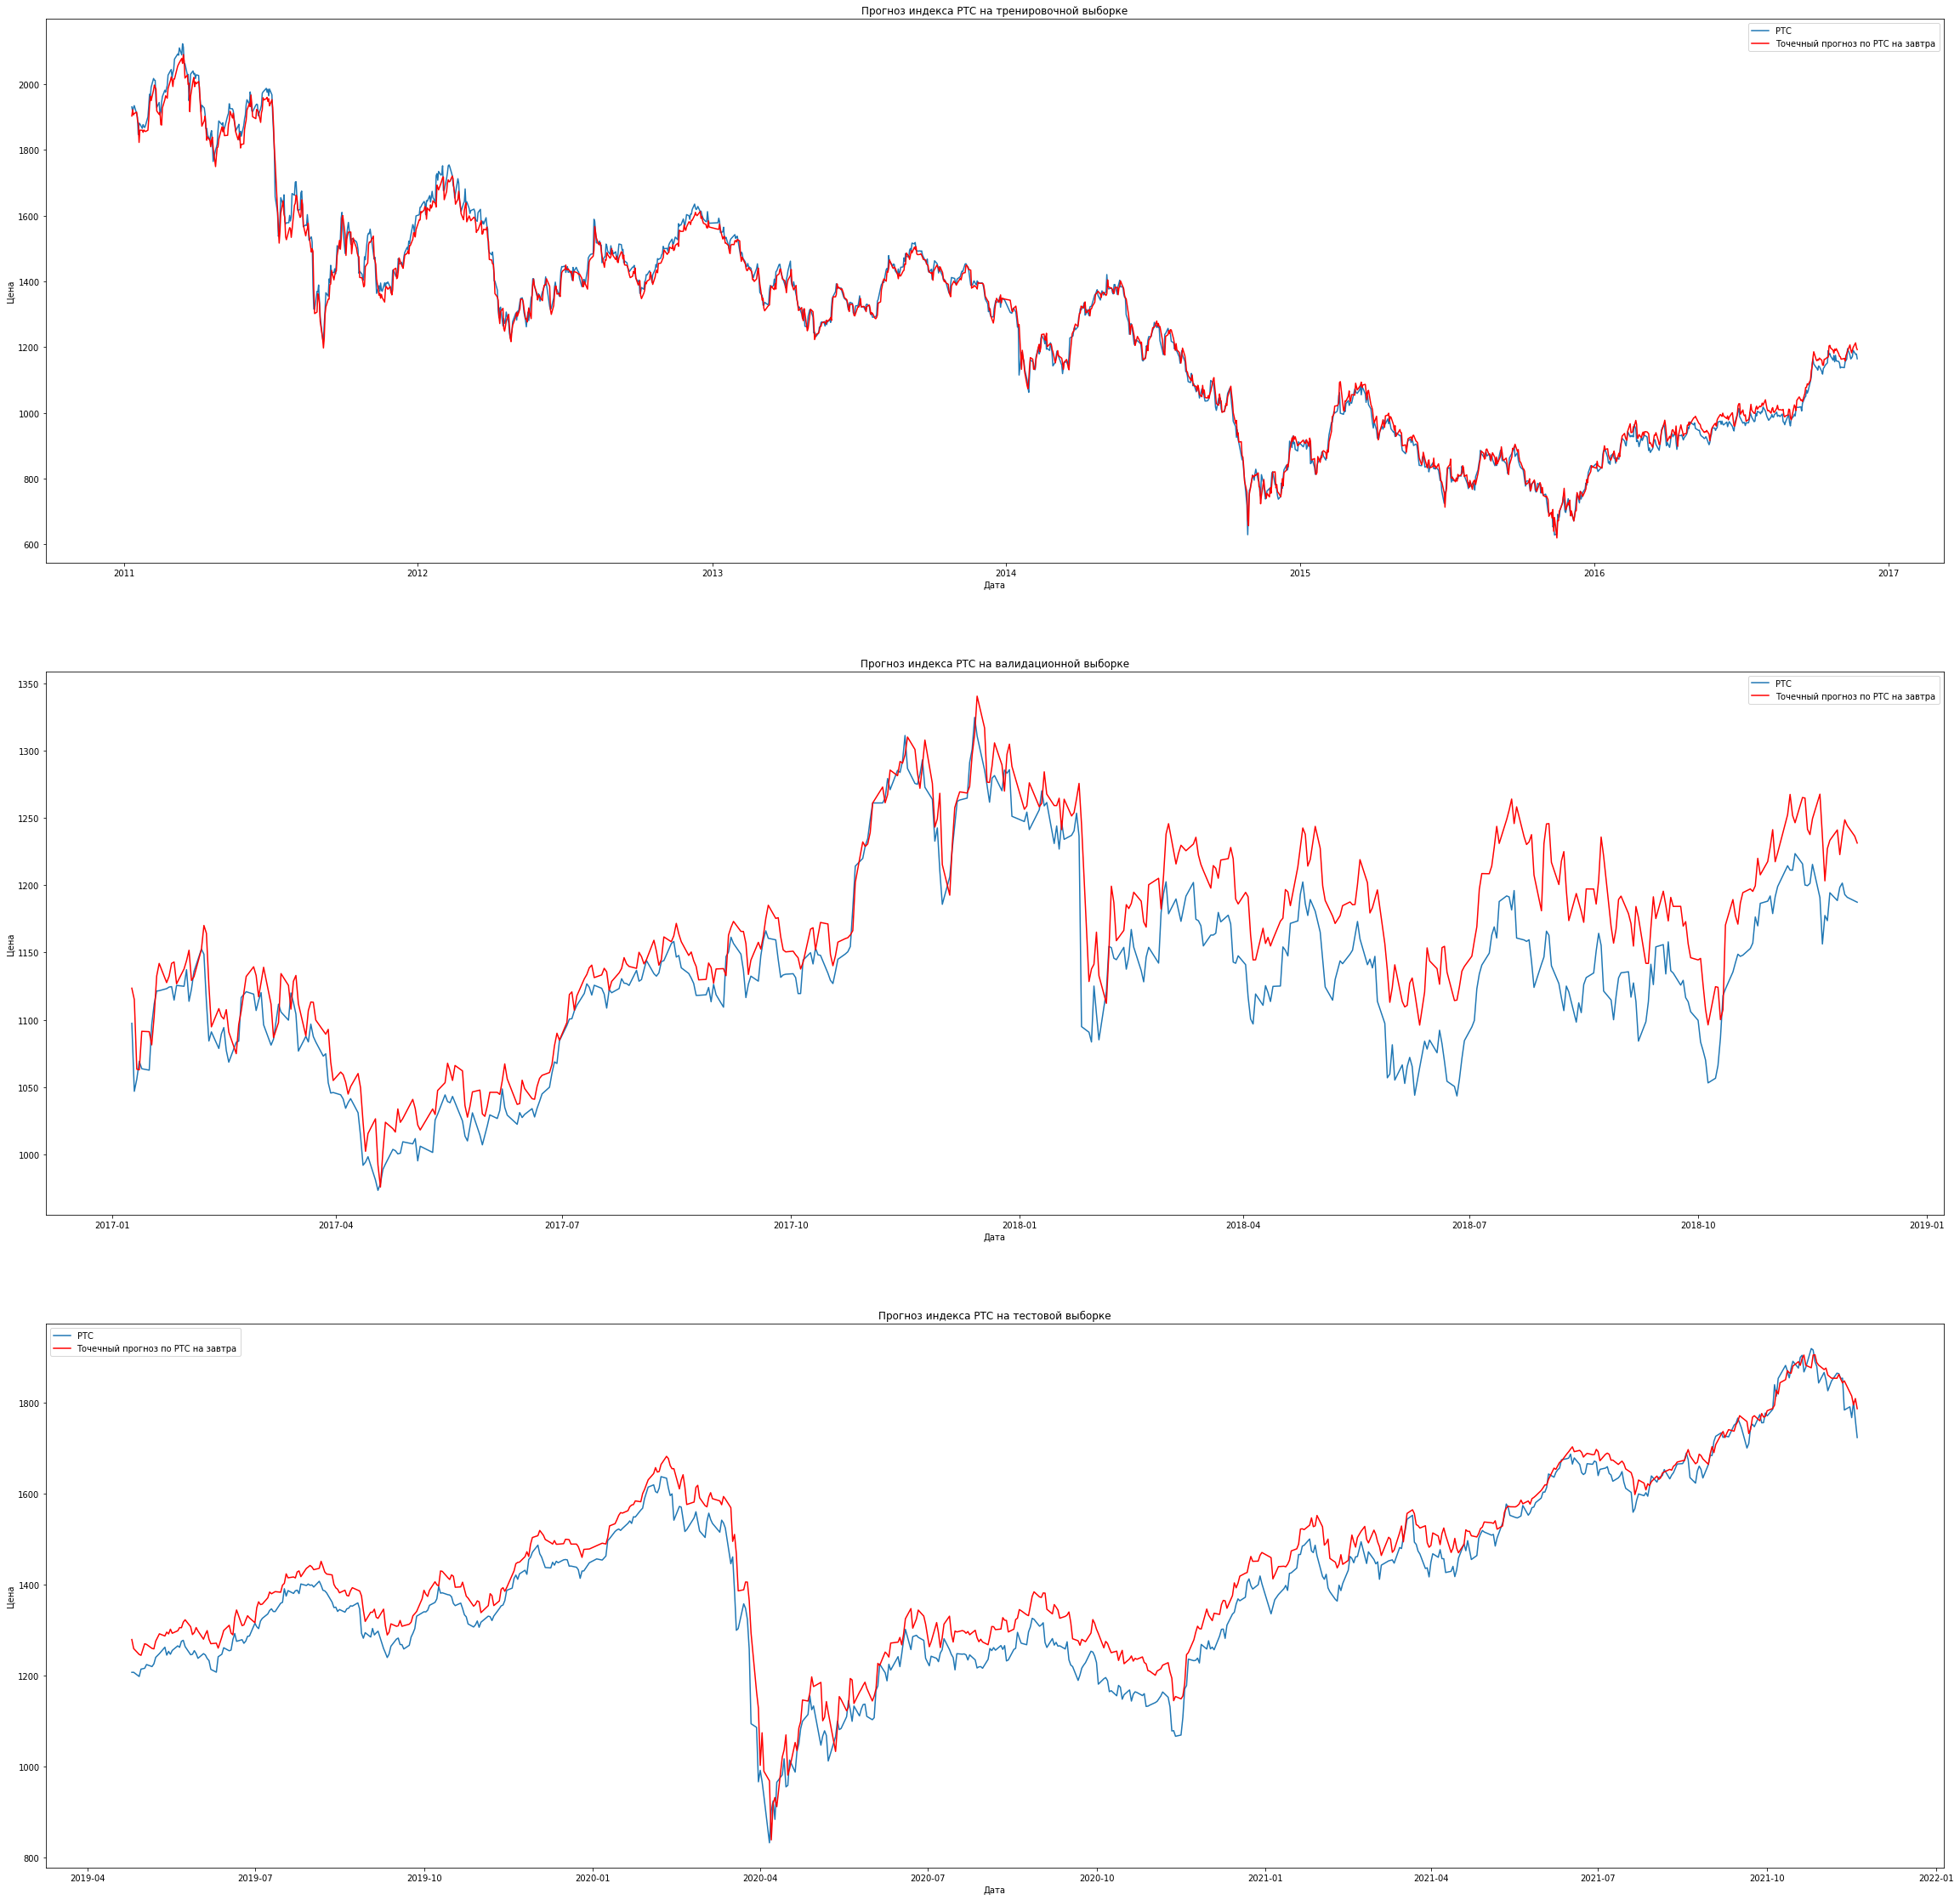

In [20]:
import matplotlib.pyplot as plt
import datetime as dt

data3 = data.copy()
mean = data3[:train_index].mean(axis=0)
data3 -= mean
std = data3[:train_index].std(axis=0)
data3 /= std

price = parser('RTSI')
price['date'] = pd.to_datetime(price['date'],format='%Y%m%d', errors='ignore')

x_train_single, y_train_single = narezka(dataset = data3,
                                     target = data3[:,0],
                                     start_index = 0, 
                                     end_index = train_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

x_val_single, y_val_single = narezka(dataset = data3,
                                     target = data3[:,0],
                                     start_index = train_index+1, 
                                     end_index = val_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

x_test_single,y_test_single = narezka(dataset = data3,
                                     target = data3[:,0],
                                     start_index = val_index+1, 
                                     end_index = len(data3), 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = True)

train_predictions = model.predict(x_train_single)
val_predictions = model.predict(x_val_single)
test_predictions = model.predict(x_test_single)

fig=plt.figure(figsize = (40,40))

ax1 = fig.add_subplot(311, title = 'Прогноз индекса РТС на тренировочной выборке',xlabel = 'Дата', ylabel = 'Цена')
ax1.plot(price['date'][:len(train_predictions)], y_train_single.reshape(-1)*std[0]+mean[0], '-', label='РТС')
ax1.plot(price['date'][:len(train_predictions)], train_predictions.reshape(-1)*std[0]+mean[0], '-', label='Точечный прогноз по РТС на завтра',color='red')
ax1.legend()

ax2 = fig.add_subplot(312, title = 'Прогноз индекса РТС на валидационной выборке',xlabel = 'Дата', ylabel = 'Цена')
ax2.plot(price['date'][train_index+oglyadka+1:val_index], y_val_single.reshape(-1)*std[0]+mean[0], '-', label='РТС')
ax2.plot(price['date'][train_index+oglyadka+1:val_index], val_predictions.reshape(-1)*std[0]+mean[0], '-', label='Точечный прогноз по РТС на завтра',color='red')
ax2.legend()

ax3 = fig.add_subplot(313, title = 'Прогноз индекса РТС на тестовой выборке',xlabel = 'Дата', ylabel = 'Цена')
ax3.plot(price['date'][-len(test_predictions):], y_test_single.reshape(-1)*std[0]+mean[0], '-', label='РТС')
ax3.plot(price['date'][-len(test_predictions):], test_predictions.reshape(-1)*std[0]+mean[0], '-', label='Точечный прогноз по РТС на завтра',color='red')
ax3.legend()

plt.show

In [21]:
print(f'''Точечный прогноз: 
MAE нормализованное на тестовой выборке = {model.evaluate(x_test_single,y_test_single,verbose =0)},
MAE с поправкой на нормализацию на тестовой выборке = {model.evaluate(x_test_single,y_test_single,verbose =0)*std[0]}''')

Точечный прогноз: 
MAE нормализованное на тестовой выборке = 0.13031738996505737,
MAE с поправкой на нормализацию на тестовой выборке = 44.11685360196578


# ВЫПОЛНЕНЕ ИНТЕРВАЛЬНОГО ПРОГНОЗА

In [5]:
# Модель по интервальный прогноз 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import datetime as dt

future_target = 5

data3 = data.copy()
mean = data3[:train_index].mean(axis=0)
data3 -= mean
std = data3[:train_index].std(axis=0)
data3 /= std

x_train_interval, y_train_interval = narezka(dataset = data3,
                                     target = data3[:,0],
                                     start_index = 0, 
                                     end_index = train_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = False)

x_val_interval, y_val_interval = narezka(dataset = data3,
                                     target = data3[:,0],
                                     start_index = train_index, 
                                     end_index = val_index, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = False)

x_test_interval,y_test_interval = narezka(dataset = data3,
                                     target = data3[:,0],
                                     start_index = val_index, 
                                     end_index = None, 
                                     history_size = oglyadka,
                                     target_size = future_target, 
                                     step = step,
                                     single_prediction = False)

#---------------------------------------------------------------------------------------
neurons = 352
num_epochs = 60
batch_size = 32

model = Sequential()
model.add(layers.LSTM(neurons,
                      input_shape = x_train_interval.shape[-2:]))
model.add(layers.Dense(future_target))
model.compile(optimizer=RMSprop(), loss='mae')

fitted_model = model.fit(x_train_interval,
                         y_train_interval,
                         epochs=num_epochs,
                         batch_size=batch_size,
                         validation_data=(x_val_interval, y_val_interval),
                         verbose=0)
#---------------------------------------------------------------------------------------

In [8]:
import matplotlib.pyplot as plt
preds = x_test_interval[:, -1, 0]

MAE1 = model.evaluate(x_test_interval[:130],y_test_interval[:130],verbose=0)[0]*std[0]
MAE1b = np.mean(np.abs(preds[:130] - y_test_interval[:130]))*std[0]

# MAE 2 с поправкой на нормализацию на тестовой выборке = {model.evaluate(x_test_single[130:260],y_test_single[130:260],verbose=0)[0]*std[0]},
# MAE 2 базовое = {np.mean(np.abs(preds[130:260] - y_test_single[130:260]))*std[0]},
# MAE 3 с поправкой на нормализацию на тестовой выборке = {model.evaluate(x_test_single[260:390],y_test_single[260:390],verbose=0)[0]*std[0]},
# MAE 3 базовое = {np.mean(np.abs(preds[260:390] - y_test_single[260:390]))*std[0]},
# MAE 4 с поправкой на нормализацию на тестовой выборке = {model.evaluate(x_test_single[390:520],y_test_single[390:520],verbose=0)[0]*std[0]},
# MAE 4 базовое = {np.mean(np.abs(preds[390:520] - y_test_single[390:520]))*std[0]},
# MAE 5 с поправкой на нормализацию на тестовой выборке = {model.evaluate(x_test_single[520:650],y_test_single[520:650],verbose=0)[0]*std[0]},
# MAE 5 базовое = {np.mean(np.abs(preds[520:650] - y_test_single[520:650]))*std[0]},''')

TypeError: 'float' object is not subscriptable

In [ ]:
preds = x_train_[:, -1, 0]
mae_with_normalization = np.mean(np.abs(preds - y_train_single))

print(f'''Точечный прогноз: 
MAE нормализованное на тестовой выборке = {model.evaluate(x_test_single,y_test_single,verbose=0)},
MAE с поправкой на нормализацию на тестовой выборке = {model.evaluate(x_test_single,y_test_single,verbose=0)[0]*std[0]},
MAE базовое = {mae_with_normalization*std[0]}.''')

print(f'''
MAE 1 с поправкой на нормализацию на тестовой выборке = {model.evaluate(x_test_single[:130],y_test_single[:130],verbose=0)[0]*std[0]},
MAE 1 базовое = {np.mean(np.abs(preds[:130] - y_train_single[:130]))*std[0]},
MAE 2 с поправкой на нормализацию на тестовой выборке = {model.evaluate(x_test_single[130:260],y_test_single[130:260],verbose=0)[0]*std[0]},
MAE 2 базовое = {np.mean(np.abs(preds[130:260] - y_train_single[130:260]))*std[0]},
MAE 3 с поправкой на нормализацию на тестовой выборке = {model.evaluate(x_test_single[260:390],y_test_single[260:390],verbose=0)[0]*std[0]},
MAE 3 базовое = {np.mean(np.abs(preds[260:390] - y_train_single[260:390]))*std[0]},
MAE 4 с поправкой на нормализацию на тестовой выборке = {model.evaluate(x_test_single[390:520],y_test_single[390:520],verbose=0)[0]*std[0]},
MAE 4 базовое = {np.mean(np.abs(preds[390:520] - y_train_single[390:520]))*std[0]},
MAE 5 с поправкой на нормализацию на тестовой выборке = {model.evaluate(x_test_single[520:650],y_test_single[520:650],verbose=0)[0]*std[0]},
MAE 5 базовое = {np.mean(np.abs(preds[520:650] - y_train_single[520:650]))*std[0]},''')